# Deflection Models

**The deflection models calculate the deflection of the wake due to yaw-misalignment, sheared inflow etc.**

Note, this is one of the four effects of skew inflow that is handled in PyWake, see [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/YawMisalignment.html).

The deflection models take as input the downwind and crosswind distances between the source wind turbines and the destination wind turbines/sites and calculate a new set of deflected downwind and crosswind distances. This type of model is important for simulations where the turbine experiences a change in angle between the incoming flow and the rotor, for example in active yaw control or wake steering optimization.

In PyWake, there are three different wake deflection models:

- [JimenezWakeDeflection](#JimenezWakeDeflection)
- [FugaDeflection](#FugaDeflection)
- [GCLHillDeflection](#GCLHillDeflection)

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

First we create a simple function to plot the different deflection models available in PyWake.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# import and setup site and windTurbines
import py_wake
from py_wake import BastankhahGaussian
from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.examples.data.hornsrev1 import V80

site = IEA37Site(16)
x, y = [0, 400, 800], [0, 0, 0]
windTurbines = V80()
D = windTurbines.diameter()

In [12]:
def plot_deflection(deflectionModel):
    
    wfm = BastankhahGaussian(site, windTurbines, deflectionModel=deflectionModel)

    yaw = [-20,20,0]
    D = windTurbines.diameter()

    plt.figure(figsize=(14,4))
    fm = wfm(x, y, yaw=yaw, tilt=0, wd=270, ws=10).flow_map()
    fm.plot_wake_map(normalize_with=D)
    center_line = fm.min_WS_eff()
    plt.plot(center_line.x/D, center_line/D,'--k')
    plt.grid()

### JimenezWakeDeflection

The `JimenezWakeDeflection` model is implemented according to Jiménez, Á., Crespo, A. and Migoya, E. (2010), Application of a LES technique to characterize the wake deflection of a wind turbine in yaw. Wind Energ., 13: 559-572. doi:10.1002/we.380.

It is the most common wake deflection model used in PyWake and has proved to result in a decent representation of the skewed inflow behind the turbine rotor. In the study, the authors carried out a Large Eddy Simulation (LES) to characterize the turbulence behind a wind turbine given the wake deflection created by different yaw angle and thrust coefficient settings.

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

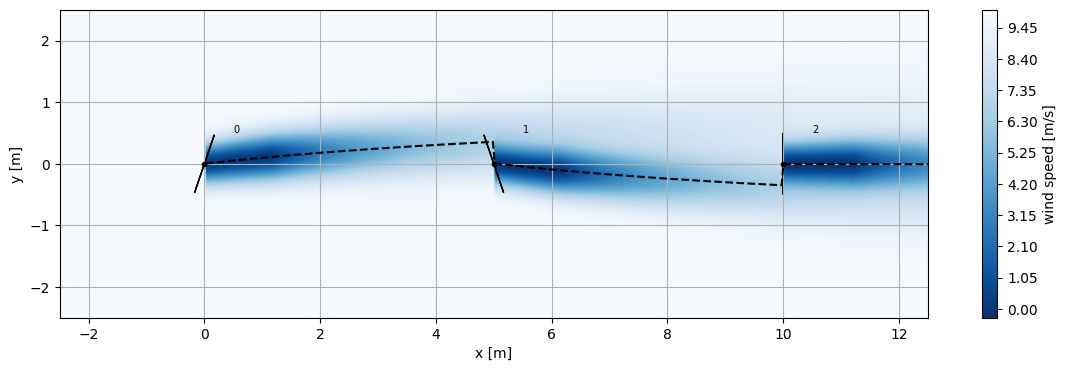

In [13]:
from py_wake.deflection_models import JimenezWakeDeflection
plt.figure()
plot_deflection(JimenezWakeDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### FugaDeflection

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

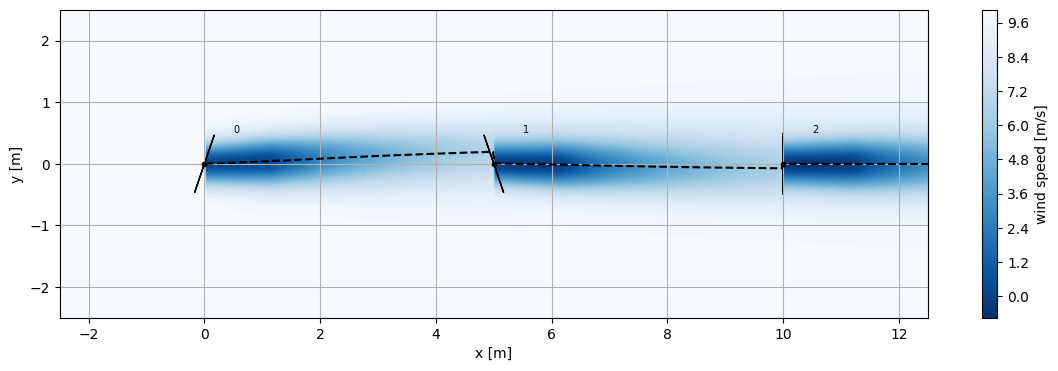

In [14]:
from py_wake.deflection_models import FugaDeflection
plt.figure()
plot_deflection(FugaDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### GCLHillDeflection

Deflection model based on Hill's ring vortex theory.

Implemented according to: Larsen, G. C., Ott, S., Liew, J., van der Laan, M. P., Simon, E., R.Thorsen, G., & Jacobs, P. (2020). Yaw induced wake deflection - a full-scale validation study. Journal of Physics - Conference Series, 1618, [062047]. https://doi.org/10.1088/1742-6596/1618/6/062047.
    
Note, this model uses the wake centerline deficit magnitude to calculate the deflection. Hence non-gaussian-shaped wake deficit models as well as deficit models with improper near wake fields, e.g. NOJDeficit, BastankhahGaussianDeficit, NiayifarGaussianDeficit, should be avoided.

As default the model uses the `WakeDeficitModel` specified for the `WindFarmModel` to calculate the magnitude of the deficit, but a separate model can be specified.

Text(0, 0.5, 'y [m]')

<Figure size 640x480 with 0 Axes>

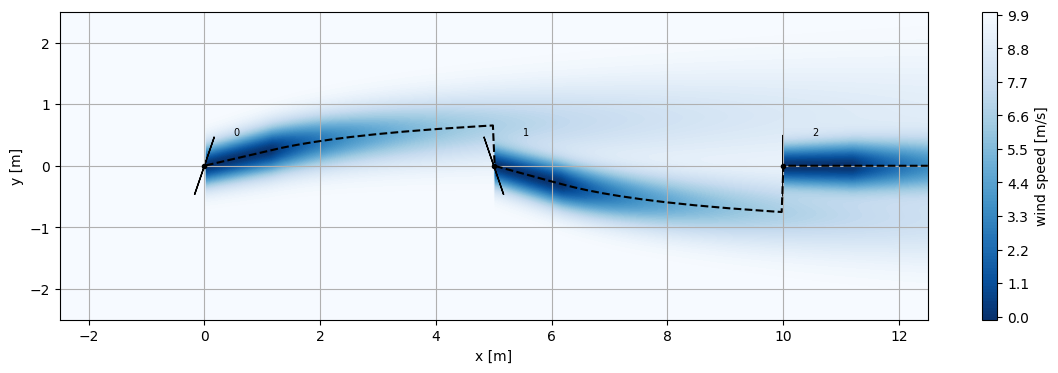

In [15]:
from py_wake.deflection_models import GCLHillDeflection
plt.figure()
plot_deflection(GCLHillDeflection())
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### You can also implement your own deflection models

Deficit models must subclass `DeficitModel` and thus must implement the `calc_deflection` method and a class variable, `args4deflection` specifying the arguments required by its calc_deflection method.

```python

class DeflectionModel(ABC):
    args4deflection = ["ct_ilk"]

    @abstractmethod
    def calc_deflection(self, dw_ijl, hcw_ijl, **kwargs):
        """Calculate deflection

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deflection

        See documentation of EngineeringWindFarmModel for a list of available input arguments

        Returns
        -------
        dw_ijlk : array_like
            downwind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        hcw_ijlk : array_like
            horizontal crosswind distance from source wind turbine(i) to destination wind turbine/site (j)
            for all wind direction (l) and wind speed (k)
        """
```

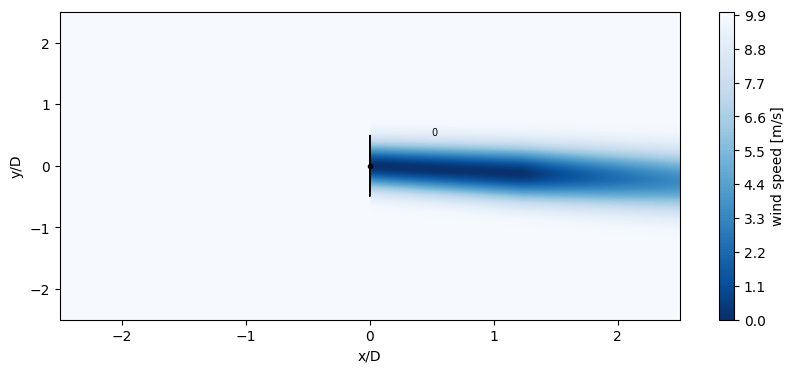

In [18]:
from py_wake.deflection_models import DeflectionModel
from numpy import newaxis as na
from py_wake import BastankhahGaussian

class MyDeflectionModel(DeflectionModel):

    def calc_deflection(self, dw_ijlk, hcw_ijlk, **_):
        hcw_ijlk =hcw_ijlk + .1*dw_ijlk       # deflect 1/10 of the downstream distance
        dh_ijlk =np.zeros_like(hcw_ijlk)      # no vertical deflection
        return dw_ijlk, hcw_ijlk, dh_ijlk

iea_my_deflection = BastankhahGaussian(site, windTurbines, deflectionModel=MyDeflectionModel())

plt.figure(figsize=(10,4))
iea_my_deflection(x=[0], y=[0], wd=270, ws=10).flow_map().plot_wake_map(normalize_with=D)
plt.xlabel('x/D')
plt.ylabel('y/D');